# Model 1: Dense Sequential

In [1]:
import time
import numpy as np
import pandas as pd
import random

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,make_scorer

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input,Dense, Flatten, Concatenate, Reshape,Embedding,Dropout
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

## M1.1 Data Preprocessing

In [2]:
X_train_M1 = pd.read_csv('X_train.csv')
X_test_M1 = pd.read_csv('X_test.csv')
y_train_M1 = pd.read_csv('y_train.csv')
y_test_M1 = pd.read_csv('y_test.csv')

In [3]:
y_train_M1 = y_train_M1.to_numpy()
y_test_M1 = y_test_M1.to_numpy()

In [4]:
X_train_M1 = X_train_M1.drop(columns=["Model","Title","ColourExtInt"]) #Drop the text columns
X_test_M1 = X_test_M1.drop(columns=["Model","Title","ColourExtInt"])

In [5]:
seed = 2024
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Split the training data into training and validation sets
X_train_M1, X_val_M1, y_train_M1, y_val_M1 = train_test_split(X_train_M1, y_train_M1, test_size=0.2, random_state=2024)


In [6]:
X_train_M1.columns

Index(['Brand', 'Year', 'UsedOrNew', 'Transmission', 'DriveType', 'FuelType',
       'FuelConsumption', 'Kilometres', 'CylindersinEngine', 'BodyType',
       'Doors', 'Seats', 'State', 'Cylinders', 'Capacity'],
      dtype='object')

In [7]:
# Define categorical and ordinal variables
cat_vars = ['Brand', 'UsedOrNew', 'Transmission', 'DriveType', 'FuelType', 
                      'BodyType', 'Doors', 'Seats', 'State']
ordinal_vars = ["CylindersinEngine"]

# Define the column transformer
ct = make_column_transformer(
    (OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat_vars),
    (OrdinalEncoder(), ordinal_vars),
    remainder=StandardScaler(),  # Apply StandardScaler() to the remaining columns
    verbose_feature_names_out=False
)

# Apply the column transformer to the data
X_train_ct_M1 = ct.fit_transform(X_train_M1)
X_val_ct_M1 =ct.transform(X_val_M1)
X_test_ct_M1 =ct.transform(X_test_M1)

## M1.2 Model Construction

In [8]:
def create_modelR(seed=2024):
    random.seed(seed)
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(Input(X_train_ct_M1.shape[1:]))
    model.add(Dense(32, "leaky_relu"))
    model.add(Dense(16, "leaky_relu"))
    model.add(Dense(1, activation='linear'))  

    return model


In [9]:
model_regress = create_modelR()
model_regress.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         4,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model_regress.compile(optimizer="adam", loss="mse", metrics=["mae"])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

start_time_fit = time.time()
history_regress = model_regress.fit(X_train_ct_M1,y_train_M1, epochs=200, verbose=0, callbacks=[early_stopping], validation_data=(X_val_ct_M1, y_val_M1)
          );

end_time_fit = time.time()
fit_time = end_time_fit - start_time_fit
print(f"Model fitting time: {fit_time} seconds")

Model fitting time: 17.940203189849854 seconds


In [11]:
# Predict on the test data
log_yr_pred_M1 = model_regress.predict(X_test_ct_M1, verbose=0)

# Apply the exponential function to the predictions to revert to the original scale
yr_pred_M1 = np.exp(log_yr_pred_M1)

# Evaluate the model on the test data by calculating RMSE and MAE manually
test_rmse_M1 = np.sqrt(np.mean((yr_pred_M1 - y_test_M1)**2))
test_mae_M1 = np.mean(np.abs(yr_pred_M1 - y_test_M1))

# Create a dictionary with the results
results = {
    'RMSE': [round(test_rmse_M1, 2)],
    'MAE': [round(test_mae_M1, 2)],
    'Number of Samples': [len(y_test_M1)]
}

results_M1 = pd.DataFrame(results)
results_M1



,RMSE,MAE,Number of Samples
0,9491.75,4933.75,4013


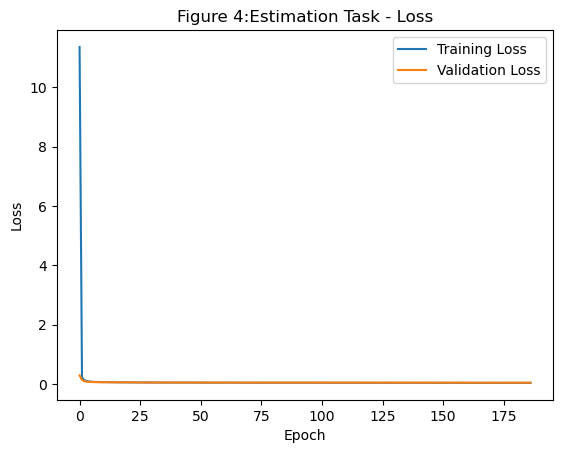

In [12]:
# Plot the loss for training and validation data
plt.plot(history_regress.history['loss'], label='Training Loss')
plt.plot(history_regress.history['val_loss'], label='Validation Loss')
plt.title('Figure 4:Estimation Task - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## M1.3 Hyperparameter Tuning

### M1.3.1 Dropout Experiment

In [13]:
def create_modelRDO(seed=2024):
    random.seed(seed)
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(Input(X_train_ct_M1.shape[1:]))
    model.add(Dense(32, "leaky_relu"))
    model.add(Dropout(0.05))
    model.add(Dense(16, "leaky_relu"))
    model.add(Dense(1, activation='linear'))  

    return model


In [14]:
model_regress2 = create_modelRDO()
model_regress2.compile(optimizer="adam", loss="mse", metrics=["mae"])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

start_time_fit = time.time()
history_regress2 = model_regress2.fit(X_train_ct_M1,y_train_M1, epochs=200, verbose=0, callbacks=[early_stopping], validation_data=(X_val_ct_M1, y_val_M1)
          );

end_time_fit = time.time()
fit_time = end_time_fit - start_time_fit
print(f"Model fitting time: {fit_time} seconds")

Model fitting time: 3.321725845336914 seconds


In [15]:
# Predict on the test data
log_yr_pred_M1 = model_regress2.predict(X_test_ct_M1, verbose=0)

# Apply the exponential function to the predictions to revert to the original scale
yr_pred_M1 = np.exp(log_yr_pred_M1)

# Evaluate the model on the test data by calculating RMSE and MAE manually
test_rmse = np.sqrt(np.mean((yr_pred_M1 - y_test_M1)**2))
test_mae = np.mean(np.abs(yr_pred_M1 - y_test_M1))

# Create a dictionary with the results
results = {
    'RMSE': [round(test_rmse, 2)],
    'MAE': [round(test_mae, 2)],
    'Number of Samples': [len(y_test_M1)]
}

# Convert the dictionary to a DataFrame
results_M1_DO = pd.DataFrame(results)
results_M1_DO

,RMSE,MAE,Number of Samples
0,12701.64,6540.35,4013


### M1.3.2 Grid Search for number of layers, number of neurons, batch sizes and learning rates

In [16]:
def create_model(seed, num_layers, num_neurons, activation, learning_rate, input_shape):
    random.seed(seed)
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    for _ in range(num_layers):
        model.add(Dense(num_neurons, activation=activation))
    model.add(Dense(16, "leaky_relu"))
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [47]:
# Experimentation setup
activations = ['leaky_relu']
layers = [1,2,3]
neurons = [8,16,32,64]
batch_sizes = [32, 64]
learning_rates = [0.001, 0.005, 0.01]

results = []

for activation in activations:
    for layer in layers:
        for neuron in neurons:
            for batch_size in batch_sizes:
                for learning_rate in learning_rates:
                    # Create the model
                    model = create_model(2024, num_layers=layer, num_neurons=neuron, activation=activation, learning_rate=learning_rate, input_shape=X_train_ct_M1.shape[1])

                    # Set up early stopping
                    es = EarlyStopping(patience=20, restore_best_weights=True, monitor="val_loss", verbose=0)

                    # Fit the model
                    start_time = time.time()
                    hist = model.fit(X_train_ct_M1, y_train_M1, batch_size=batch_size, callbacks=[es], epochs=200, verbose=0, validation_data=(X_val_ct_M1, y_val_M1))
                    end_time = time.time()
                    fit_time = end_time - start_time

                    # Evaluate the model
                    # eval_results = model.evaluate(X_val_ct, y_val, verbose=0)
                    # eval_results_test = model.evaluate(X_test_ct, y_test, verbose=0)

                    # Predict on the test set
                    y_pred_M1 = model.predict(X_test_ct_M1, verbose=0)
                    y_pred_M1 = np.exp(y_pred_M1)  # Apply exponential if the targets were log-transformed

                    # Calculate additional metrics
                    rmse = np.sqrt(mean_squared_error(y_test_M1, y_pred_M1))
                    mae = mean_absolute_error(y_test_M1, y_pred_M1)
                    # Get the number of epochs from the history
                    num_epochs = len(hist.history['loss'])

                    # Store the results
                    results.append({
                        'activation': activation,
                        'layers': layer,
                        'neurons': neuron,
                        'batch_size': batch_size,
                        'learning_rate': learning_rate,
                        'epochs': num_epochs,
                        'rmse': rmse,
                        'mae': mae,
                        'fit_time': fit_time
                    })

In [48]:
results_M1_GS = pd.DataFrame(results)
results_M1_GS = results_M1_GS.round(4)
results_M1_GS

,activation,layers,neurons,batch_size,learning_rate,epochs,rmse,mae,fit_time
0,leaky_relu,1,8,32,0.001,200,10396.8746,5295.5549,18.9701
1,leaky_relu,1,8,32,0.005,135,10327.8954,5307.4469,12.8705
2,leaky_relu,1,8,32,0.010,129,10368.2679,5447.9800,12.3126
3,leaky_relu,1,8,64,0.001,200,10602.3389,5539.1251,10.9811
4,leaky_relu,1,8,64,0.005,159,9962.2873,5124.5887,9.1159
...,...,...,...,...,...,...,...,...,...
67,leaky_relu,3,64,32,0.005,36,11154.9521,6022.8823,4.8171
68,leaky_relu,3,64,32,0.010,73,10134.6264,5095.6457,9.2925
69,leaky_relu,3,64,64,0.001,65,9846.6298,4902.5586,5.2463
70,leaky_relu,3,64,64,0.005,64,9492.2988,4949.6626,5.2378


### M1.3.3 Optimised Result

In [49]:
results_M1_GS[results_M1_GS['rmse']==min(results_M1_GS['rmse'])]

,activation,layers,neurons,batch_size,learning_rate,epochs,rmse,mae,fit_time
12,leaky_relu,1,32,32,0.001,187,9491.7482,4933.7512,18.1128


# Model 2: Embedding Layer for Extracting Text in `Title`

## M2.1 Data Preprocessing

In [20]:
# Set random seeds for reproducibility
seed = 2024
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Load the data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [21]:
# Prepare the combined text column for embedding
X_train['combined_text'] = X_train[['Title']].apply(lambda x: ' '.join(x.astype(str)), axis=1)
X_test['combined_text'] = X_test[['Title']].apply(lambda x: ' '.join(x.astype(str)), axis=1)

# Initialize and fit the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train['combined_text'])

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train['combined_text'])
X_test_sequences = tokenizer.texts_to_sequences(X_test['combined_text'])

# Pad sequences to ensure uniform length
max_sequence_length = max([len(seq) for seq in X_train_sequences])
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_sequences, maxlen=max_sequence_length)

# Prepare embedding matrix if using pre-trained embeddings
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_dim = 7 # vocab = 1885 => the fourth square root of 1885 =6.59. That's why we set 7 here.

# Initialize embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))
embedding_matrix = np.random.rand(vocab_size, embedding_dim)


In [22]:
X_train[['Model','ColourExtInt','Title']].head(10)

,Model,ColourExtInt,Title
0,CX-5,White / Black Maztex/Cloth,2022 Mazda CX-5 Touring (awd)
1,CX-9,White / -,2016 Mazda CX-9 GT (fwd)
2,Hilux,White / Black,2020 Toyota Hilux SR HI-Rider
3,Caddy,White / Black,2019 Volkswagen Caddy SWB TSI220
4,HiAce,- / -,2011 Toyota HiAce Slwb
5,Superb,White / Grey,2018 Skoda Superb 162 TSI
6,Grand,Silver / -,2022 Jeep Grand Cherokee Summit Reserve (4X4)
7,Landcruiser,Silver / Black,2018 Toyota Landcruiser Prado Kakadu (4X4)
8,Veloster,Black / -,2014 Hyundai Veloster SR Turbo
9,Triton,White / Grey,2015 Mitsubishi Triton GLX (4X4)


In [23]:
X_train[['Model','ColourExtInt','Title']].nunique()

Model            651
ColourExtInt     632
Title           6832
dtype: int64

In [24]:
# Define categorical and ordinal variables
cat_vars = ['Brand', 'UsedOrNew', 'Transmission', 'DriveType', 'FuelType', 
            'BodyType', 'Doors', 'Seats', 'State']
ordinal_vars = ["CylindersinEngine"]

# Create a pipeline for numerical columns with imputation and scaling
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())
])
# Apply column transformer to the combined data
ct = make_column_transformer(
    (OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat_vars),
    (OrdinalEncoder(), ordinal_vars),
    remainder=num_pipeline,  # Apply MinMaxScaler() to the remaining columns
    verbose_feature_names_out=False
)


# Combine the padded text sequences with the original structured data
X_train_combined = pd.concat([X_train.drop(columns=['Model', 'Title',  'ColourExtInt',  'combined_text']), pd.DataFrame(X_train_padded)], axis=1)
X_test_combined = pd.concat([X_test.drop(columns=['Model', 'Title',  'ColourExtInt',  'combined_text']), pd.DataFrame(X_test_padded)], axis=1)

# Ensure all column names are strings
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Apply the column transformer to the data
X_train_ct = ct.fit_transform(X_train_combined)
X_test_ct = ct.transform(X_test_combined)

# Split the training data into new training set and validation set
X_train_ct_new, X_val_ct, X_train_padded_new, X_val_padded, y_train_new, y_val = train_test_split(
    X_train_ct, X_train_padded, y_train, test_size=0.2, random_state=seed
)

In [25]:
# Define the combined model
def create_combined_model(seed=2024):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True)
    # Define input layers
    structured_input = Input(shape=(X_train_ct.shape[1],))
    text_input = Input(shape=(max_sequence_length,))
    

    # Define the text embedding layer
    text_embedding = embedding_layer(text_input)
    text_flatten = Flatten()(text_embedding)

    # Concatenate structured and text features
    combined = Concatenate()([structured_input, text_flatten])

    # Add dense layers
    x = Dense(128, activation='leaky_relu')(combined)
    x = Dense(128, activation='leaky_relu')(x)
    x = Dense(32, activation='leaky_relu')(x)
    output = Dense(1, activation='linear')(x)

    # Create and compile the model
    optimizer = Adam(learning_rate=0.0005)
    model = Model(inputs=[structured_input, text_input], outputs=output)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# Create and summarize the model
model_combined = create_combined_model()
model_combined.summary()

Model: "functional_175"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_51      │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 17, 7)     │     13,195 │ input_layer_51[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_50      │ (None, 142)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 119)       │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 261)       │          0 │ input_layer_50[0… │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_174 (Dense)   │ (None, 128)       │     33,536 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_175 (Dense)   │ (None, 128)       │     16,512 │ dense_174[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_176 (Dense)   │ (None, 32)        │      4,128 │ dense_175[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_177 (Dense)   │ (None, 1)         │         33 │ dense_176[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,404 (263.30 KB)

 Trainable params: 67,404 (263.30 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
#plot_model(model_combined, to_file='combined_model.png', show_shapes=True, show_layer_names=True)  #Plot the Network Architecture

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start_time_fit = time.time()
history_combined = model_combined.fit(
    [X_train_ct_new, X_train_padded_new], y_train_new,
    validation_data=([X_val_ct, X_val_padded], y_val),
    callbacks=[early_stopping], 
    epochs=200,  
    verbose=0
)

end_time_fit = time.time()
fit_time = end_time_fit - start_time_fit
print(f"Model fitting time: {fit_time} seconds")

# Predict on the test data
log_yr_pred = model_combined.predict([X_test_ct, X_test_padded], verbose=0)
yr_pred = np.exp(log_yr_pred)

# Evaluate the model on the test data by calculating RMSE and MAE manually
test_rmse = np.sqrt(np.mean((yr_pred - y_test)**2))
test_mae = np.mean(np.abs(yr_pred - y_test))

# Create a dictionary with the results
results = {
    'RMSE': [round(test_rmse, 2)],
    'MAE': [round(test_mae, 2)],
    'Number of Samples': [len(y_test)]
}

# Convert the dictionary to a DataFrame
results_df_EM = pd.DataFrame(results)
results_df_EM


Model fitting time: 14.414609909057617 seconds


,RMSE,MAE,Number of Samples
0,8084.84,3893.37,4013


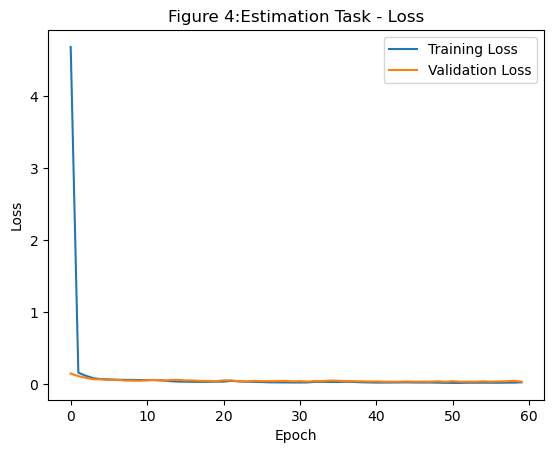

In [28]:
# Plot the loss for training and validation data
plt.plot(history_combined.history['loss'], label='Training Loss')
plt.plot(history_combined.history['val_loss'], label='Validation Loss')
plt.title('Figure 4:Estimation Task - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## M2.2 Hyperparameter Tuning

### M2.2.1 Dropout Experiment

In [40]:
# Define the combined model with dropout
def create_combined_model_DO(seed=2024):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True)
    # Define input layers
    structured_input = Input(shape=(X_train_ct.shape[1],))
    text_input = Input(shape=(max_sequence_length,))
    

    # Define the text embedding layer
    text_embedding = embedding_layer(text_input)
    text_flatten = Flatten()(text_embedding)

    # Concatenate structured and text features
    combined = Concatenate()([structured_input, text_flatten])

    # Add dense layers
    x = Dense(128, activation='leaky_relu')(combined)
    x = Dense(128, activation='leaky_relu')(x)
    x = Dropout(0.1) (x)
    x = Dense(32, activation='leaky_relu')(x)
    output = Dense(1, activation='linear')(x)

    # Create and compile the model
    optimizer = Adam(learning_rate=0.0005)
    model = Model(inputs=[structured_input, text_input], outputs=output)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [41]:
model_combinedOU = create_combined_model_DO()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start_time_fit = time.time()
history_combinedOU = model_combinedOU.fit(
    [X_train_ct_new, X_train_padded_new], y_train_new,
    validation_data=([X_val_ct, X_val_padded], y_val),
    callbacks=[early_stopping], 
    epochs=200,  
    verbose=0
)

end_time_fit = time.time()
fit_time = end_time_fit - start_time_fit
print(f"Model fitting time: {fit_time} seconds")

# Predict on the test data
log_yr_pred = model_combinedOU.predict([X_test_ct, X_test_padded], verbose=0)
yr_pred = np.exp(log_yr_pred)

# Evaluate the model on the test data by calculating RMSE and MAE manually
test_rmse = np.sqrt(np.mean((yr_pred - y_test)**2))
test_mae = np.mean(np.abs(yr_pred - y_test))

# Create a dictionary with the results
results = {
    'RMSE': [round(test_rmse, 2)],
    'MAE': [round(test_mae, 2)],
    'Number of Samples': [len(y_test)]
}

# Convert the dictionary to a DataFrame
results_df_EM_2 = pd.DataFrame(results)
results_df_EM_2


Model fitting time: 2.79547119140625 seconds


,RMSE,MAE,Number of Samples
0,15673.7,8743.25,4013


### M2.2.2 Grid Search for number of layers, number of neurons, batch sizes and learning rates

In [42]:
def create_combined_model2(seed, num_layers, num_neurons, activation, learning_rate, 
                          structured_input_shape):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Define input layers
    structured_input = Input(shape=(structured_input_shape,))
    text_input = Input(shape=(max_sequence_length,))
    
    embedding_layer2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True)


    # Define the text embedding layer
    text_embedding = embedding_layer2(text_input)
    text_flatten = Flatten()(text_embedding)

    # Concatenate structured and text features
    combined = Concatenate()([structured_input, text_flatten])

    # Add dense layers
    x = combined
    for _ in range(num_layers):
        x = Dense(num_neurons, activation=activation)(x)
    x = Dense(32, activation='leaky_relu')(x)
    output = Dense(1, activation='linear')(x)

    # Create and compile the model
    model = Model(inputs=[structured_input, text_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [43]:
# Experimentation setup
activations = ['leaky_relu']
layers = [1,2,3]
neurons = [32,64,128,256]
batch_sizes = [32] # Tried 64 and 128 => nearly no difference
learning_rates = [0.0005, 0.001, 0.002]

results = []

# Grid search loop
for activation in activations:
    for layer in layers:
        for neuron in neurons:
            for batch_size in batch_sizes:
                for learning_rate in learning_rates:
                    # Create the model
                    model_combined = create_combined_model2(
                        2024, 
                        num_layers=layer, 
                        num_neurons=neuron, 
                        activation=activation, 
                        learning_rate=learning_rate, 
                        structured_input_shape=X_train_ct.shape[1]
                    )

                    # Set up early stopping
                    early_stopping = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss", verbose=0)

                    # Fit the model
                    start_time_fit = time.time()
                    history_combined = model_combined.fit(
                        [X_train_ct_new, X_train_padded_new], y_train_new,
                        validation_data=([X_val_ct, X_val_padded], y_val),
                        callbacks=[early_stopping], 
                        epochs=200,  
                        verbose=0
                    )
                    end_time_fit = time.time()
                    fit_time = end_time_fit - start_time_fit

                    # Predict on the test data
                    log_yr_pred = model_combined.predict([X_test_ct, X_test_padded], verbose=0)
                    yr_pred = np.exp(log_yr_pred)

                    # Evaluate the model on the test data by calculating RMSE and MAE manually
                    test_rmse = np.sqrt(np.mean((yr_pred - y_test)**2))
                    test_mae = np.mean(np.abs(yr_pred - y_test))

                    # Get the number of epochs from the history
                    num_epochs = len(history_combined.history['loss'])

                    # Store the results
                    results.append({
                        'activation': activation,
                        'layers': layer,
                        'neurons': neuron,
                        'batch_size': batch_size,
                        'learning_rate': learning_rate,
                        'epochs': num_epochs,
                        'rmse': test_rmse,
                        'mae': test_mae,
                        'fit_time': fit_time
                    })


In [44]:
results_df2 = pd.DataFrame(results)
results_df2 = results_df2.round(4)
results_df2

,activation,layers,neurons,batch_size,learning_rate,epochs,rmse,mae,fit_time
0,leaky_relu,1,32,32,0.0005,57,8969.8420,4181.9649,7.1191
1,leaky_relu,1,32,32,0.0010,25,9112.5101,4500.3484,3.3191
2,leaky_relu,1,32,32,0.0020,25,8878.3180,4385.5945,3.3420
3,leaky_relu,1,64,32,0.0005,36,14813.8385,4399.3709,5.0271
4,leaky_relu,1,64,32,0.0010,50,8937.1801,4175.1593,6.9262
5,leaky_relu,1,64,32,0.0020,40,11989.8970,4446.2472,5.6102
6,leaky_relu,1,128,32,0.0005,45,8464.8029,4094.2555,7.6418
7,leaky_relu,1,128,32,0.0010,29,8607.5525,4217.8542,5.0526
8,leaky_relu,1,128,32,0.0020,39,8592.6342,4240.7266,6.8313
9,leaky_relu,1,256,32,0.0005,63,8164.4941,3851.6405,15.0193


### M2.2.3 Optimised Result¶

In [45]:
results_df2[results_df2['rmse']==min(results_df2['rmse'])]

,activation,layers,neurons,batch_size,learning_rate,epochs,rmse,mae,fit_time
18,leaky_relu,2,128,32,0.0005,60,8084.8415,3893.3737,11.9288
